# 3rd Assignment: Sentiment Analysis

---
>Vasileios Galanos <br>
>Registration Number p3351902 <br>
>vgalanos@aueb.gr

This notebook accompanied with the report given provides our solution to the 2nd assignment of the Text Analytics course at Data Science MSc at AUEB. <br>

#### Install required packages


In [0]:
%%capture
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install --upgrade tensorflow
!pip install emoji --upgrade

#### Mount drive to colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Check the GPU allocated

In [3]:
!nvidia-smi

Sat Jun  6 13:21:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Import all libraries for later use

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import re
import itertools
import emoji
import time

from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup 
from nltk.stem import WordNetLemmatizer
from gensim.models.wrappers import FastText
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from tabulate import tabulate
from sklearn.metrics import auc

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [5]:
nltk.download('wordnet',quiet=True)
#nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)

True

#### Download, unzip & load fasttext word embeddings

In [6]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip -d cc.en.300.bin.gz

--2020-06-06 13:22:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  12.0MB/s    in 5m 58s  

2020-06-06 13:28:12 (12.0 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [7]:
fasttext = FastText.load_fasttext_format('cc.en.300.bin')
fasttext

#### Download a sentiment analysis dataset

In [8]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip "trainingandtestdata.zip"

--2020-06-06 13:39:14--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-06-06 13:39:14--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  21.0MB/s    in 4.5s    

2020-06-06 13:39:19 (17.2 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


#### Load Data from csv file & remove useless columns

In [9]:
pd.set_option('max_colwidth', 800)
cols = ['sentiment','id','date','query_string','user','text']
tweets_final = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None, names=cols) #import data to dataframe

tweets_final.drop(['id','date','query_string','user'],axis=1,inplace=True) # drop useless columns
tweets_final.loc[tweets_final['sentiment'] == 4, "sentiment"] = 1 #change labels

tweets_final.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


#### Delete unnecessary files

In [0]:
!rm testdata.manual.2009.06.14.csv
!rm cc.en.300.bin
!rm training.1600000.processed.noemoticon.csv
!rm trainingandtestdata.zip

#### Get a count of data to see that there are no neutral tweets

In [10]:
tweets_final.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

### Data preprocessing/ cleaning/ preparation

##### Create a dictionary with contractions and smileyfaces
https://github.com/charlesmalafosse/FastText-sentiment-analysis-for-tweets/blob/master/betsentiment_sentiment_analysis_fasttext.py

In [0]:
def load_dict_smileys():
    
    return {
        ":-)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }


def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

##### Cleaning

In [12]:
lemmatizer = WordNetLemmatizer()

def tweet_cleaner(tweet):

    #remove references
    pat1 = r'@[A-Za-z0-9]+'
    #remove links
    pat2 = r"(\w+:\/\/\S+)"
    combined_pat1 = r'|'.join((pat1, pat2))

    #remove hashtags, numbers
    pat4 = "(#[A-Za-z0-9]+)" #r'\^[a-zA-Z!]\s+' 
    # Substituting multiple spaces with single space
    pat5 = r'\s+'
    combined_pat2 = r'|'.join((pat4, pat5))

    #remove html related tags
    tweet = BeautifulSoup(tweet, 'lxml')
    tweet = tweet.get_text()
    
    tweet = re.sub(combined_pat1, '', tweet)
    tweet = re.sub(combined_pat2, ' ', tweet)

    try:
        #replace possibe faulty characters
        tweet = tweet.replace(u"\ufffd", "?")
    except:
        tweet = tweet
    tweet = tweet.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  

    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words] #replace contractions
    reformed2 = [SMILEY[word] if word in SMILEY else word for word in reformed] #replace smileys
    reformed2 = [lemmatizer.lemmatize(word) for word in reformed2] #lemmatize
    tweet = " ".join(reformed2)
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))

    #Deal with emojis
    tweet = emoji.demojize(tweet)

    #Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    #keep only letters
    tweet = re.sub("[^a-zA-Z!]", " ", tweet)
    #lemmatize
    words = tweet.split()
    reformed = [lemmatizer.lemmatize(word) for word in words]
    tweet = " ".join(reformed)
    # Substituting multiple spaces with single space
    tweet = ' '.join(re.sub("\s+", " ", tweet).split())
    return tweet

#test cleaner
print(tweet_cleaner("@someone Lots of rocks 👍 fell frommmmm the skies.... :-) He'll consider taken an umbrella <3 ?! 95345!! #rocksfell  https://www.fsdf.gr http://asdfsdf/w"))

lot of rock thumb up fell fromm the sky smiley he will consider taken an umbrella love


#### Clean dataset

In [13]:
# set N for sample size
N = 100000

start_time = time.time()

# shuffle
tweets_final = tweets_final.sample(frac=1)

# get a subspace of the original dataset and preproccess it
tweets_final = tweets_final[:N]
tweets_final['text'] = tweets_final['text'].apply(lambda x : tweet_cleaner(x))

elapsed_time = time.time() - start_time

print('Time passed %0.0f seconds' % elapsed_time)

# drop empty sentences
tweets_final = tweets_final[(tweets_final['text']!='')]
tweets_final.head(4)

Time passed 65 seconds


,sentiment,text
200475,0,trouble is unless you have a piece of paper that say look i told you i can do this already they do not believe you
1270958,1,raqu l wond r omgi want travis to call me so bad lmao im inlove with a singer lolz
1138680,1,across the universe wa great i have new love for the beatles and janis joplin hey jude
160994,0,sorry is only in spanish for the moment


In [14]:
tok = WordPunctTokenizer()
def text_centroid(text, model):
    
  text_vec =[]
  counter = 0
  sent_tokenized = tok.tokenize(text)
  for word in sent_tokenized:
    try:
      if counter == 0:
        text_vec = model[word]
        counter+=1
      else:
        text_vec = np.add(text_vec, model[word])
        counter+=1
    except:
      pass
    
  return np.asarray(text_vec) / counter

start_time = time.time()

tweets_final['centroid'] = tweets_final.text.apply(lambda x : text_centroid(x, fasttext))

elapsed_time = time.time() - start_time

print('Time passed %0.0f seconds' % elapsed_time)

# drop empty centroids
tweets_final = tweets_final[tweets_final['centroid'].map(lambda d: len(d)) > 0]

Time passed 6 seconds


#### Train, Dev & Test split

In [15]:
total_length = len(tweets_final)
train_set = tweets_final[0:int((total_length*8)/10)]
print(train_set[0:3])
dev_set = tweets_final[int((total_length*8)/10)+1:int((total_length*9)/10)]
print(dev_set[0:3])
test_set = tweets_final[int((total_length*9)/10)+1:total_length]
print(test_set[0:3])

         sentiment  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         centroid
200475           0  ...  [0.0048201387, -0.035242263, 0.023707423, 0.039374247, -0.09091509, -0.04399461, -0.05705161, 0.014566073, 0.04219777, -0.037388302, -0.027243381, -0.

### Some statistics on the dataset


In [16]:
avg_doc_len = tweets_final.groupby('sentiment').text.apply(lambda x: x.str.split().str.len().mean())
print("Average document length per sentiment is: ")
print(avg_doc_len)

Average document length per sentiment is: 
sentiment
0    13.527859
1    12.345976
Name: text, dtype: float64


In [17]:
print("The total number of documents is: ", total_length, ".")

The total number of documents is:  99764 .


In [18]:
print("Training set contains: ", len(train_set)," documents.")
print("Dev set contains: ", len(dev_set)," documents.")
print("Test set contains: ", len(test_set)," documents.")

Training set contains:  79811  documents.
Dev set contains:  9975  documents.
Test set contains:  9976  documents.


In [0]:
X_train = np.stack(train_set.centroid, axis=0)
y_train = train_set.sentiment.tolist()

X_dev = np.stack(dev_set.centroid, axis=0)
y_dev = dev_set.sentiment.tolist()

X_test = np.stack(test_set.centroid, axis=0)
y_test = test_set.sentiment.tolist()

### Macro Average - Precision, Recall & F1 scores

In [0]:
def get_scores(y_true, y_scores, threshold):
  """
  input:
    y_true: array with gound truth
    y_scores: array-like, shape = [n_samples, n_classes], the probability of the sample for each class in the model
    threshold: classification threshold in order to classify to positive class

  output:
    precision: dictionary with scores for all classes + macro precision
    recall: dictionary with scores for all classes + macro recall
    f1: dictionary with scores for all classes + macro f1

  """
  N_labels = y_scores.shape[1] # number of classes
  
  precision = {}
  recall = {}
  f1 = {}

  for label in range(N_labels):
    
    # create array with predictions based on which class is considered positive and a threshold
    y_pred = np.array([int(label if elem >= threshold else 1-label) for elem in y_scores[:,label]])
  
    # calculate True Positive, False Positive, True Negative, False Negative
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
      if y_true[i]==y_pred[i]==label:
        TP += 1
      if y_pred[i]==label and y_true[i]!=y_pred[i]:
        FP += 1
      if y_pred[i]==1-label and y_true[i]!=y_pred[i]:
        FN += 1
    precision[label] = 0 if (TP + FP) == 0 else TP / (TP + FP) 
    recall[label] = 0 if (TP + FN) == 0 else TP / (TP + FN)
    f1[label] = 0 if (precision[label] + recall[label]) ==0 else 2 * (precision[label] * recall[label]) / (precision[label] + recall[label]) 

  precision['macro'] = sum(precision.values())/N_labels
  recall['macro'] = sum(recall.values())/N_labels
  f1['macro'] = sum(f1.values())/N_labels
  
  return precision, recall, f1

def print_scores(estimator, X, y_true, threshold):
  y_pred = estimator.predict_proba(X)
  prec_dict, rec_dict, f1_dict = get_scores(y_true, y_pred, threshold)
  scores_df = pd.DataFrame.from_dict({'precision': prec_dict, 'recall': rec_dict, 'f1': f1_dict})
  print(tabulate(scores_df.round(3), headers='keys', tablefmt='psql'))

### Most probable classifier as Baseline

In [21]:
def print_classifier_scores(estimator, est_name, X_train, y_train
                            ,X_dev, y_dev
                            ,X_test,y_test
                            , thres):

  print("{}- Train scores:".format(est_name))
  print_scores(estimator, X_train, y_train, thres)

  print("---------------------------------------------------------")
  print("{}- Dev scores:".format(est_name))
  print_scores(estimator, X_dev ,y_dev, thres)

  print("---------------------------------------------------------")
  print("{}- Test scores:".format(est_name))
  print_scores(estimator, X_test, y_test, thres)

# fit on training set and print scores
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

print_classifier_scores(dummy, 'Baseline', X_train, y_train
  , X_dev, y_dev
  , X_test, y_test,0.5)

Baseline- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.503 |      1   | 0.67  |
| macro |       0.252 |      0.5 | 0.335 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.498 |      1   | 0.665 |
| macro |       0.249 |      0.5 | 0.332 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Baseline- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0     |      0   | 0     |
| 1     |       0.493 |      1   | 0.661 

### Logistic Regression Classifier

In [22]:
sgd = SGDClassifier(loss="log", max_iter=5000, penalty= 'l2', alpha= 0.0001)
sgd.fit(X_train, y_train)

print_classifier_scores(sgd, 'SGD classifier', X_train, y_train
  , X_dev, y_dev
  , X_test, y_test,0.5)

SGD classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.737 |    0.745 | 0.741 |
| 1     |       0.745 |    0.738 | 0.742 |
| macro |       0.741 |    0.741 | 0.741 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.747 |    0.739 | 0.743 |
| 1     |       0.739 |    0.747 | 0.743 |
| macro |       0.743 |    0.743 | 0.743 |
+-------+-------------+----------+-------+
---------------------------------------------------------
SGD classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.753 |    0.751 | 0.752 |
| 1     |       0.745 |

### Keras MLP Classifier

In [0]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [0]:
# make lists to arrays
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

"""
 prepare two-dim y vectors for keras fit
 in order to have 2 values for predict_proba we have DENSE 2 output in keras
 thus it expects a two dimensional y vector. We create it stacking vertically the 
 suplement of y
"""
y_train2 = np.vstack((1-y_train, y_train)).T
y_dev2 = np.vstack(( 1-y_dev, y_dev)).T
y_test2 = np.vstack((1-y_test, y_test )).T

#### Define Keras MLP

In [31]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1] , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,  activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,  activation='relu'))
model.add(Dense(2,  activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=[precision, recall, f1, accuracy])

my_callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint('keras_fastetxt_centroids_model2', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
]

#model.load_weights("/content/gdrive/My Drive/keras_checkpoints/sentiment_keras_weights.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 176,002
Trainable params: 176,002
Non-trainable params: 0
________________________________________________

In [32]:
history = model.fit(X_train, y_train2,
              batch_size=32,
              epochs=30,
              verbose = 2,
              callbacks=my_callbacks,
              validation_data=(X_dev, y_dev2),
              shuffle=True)

#model.save_weights("/content/gdrive/My Drive/keras_checkpoints/sentiment_keras_weights.h5")

Train on 79811 samples, validate on 9975 samples
Epoch 1/30
 - 14s - loss: 0.5859 - precision: 0.6860 - recall: 0.6860 - f1: 0.6860 - accuracy: 0.6859 - val_loss: 0.5224 - val_precision: 0.7427 - val_recall: 0.7427 - val_f1: 0.7427 - val_accuracy: 0.7426

Epoch 00001: val_f1 improved from -inf to 0.74267, saving model to keras_fastetxt_centroids_model2
Epoch 2/30
 - 14s - loss: 0.5312 - precision: 0.7341 - recall: 0.7341 - f1: 0.7341 - accuracy: 0.7342 - val_loss: 0.5056 - val_precision: 0.7553 - val_recall: 0.7553 - val_f1: 0.7553 - val_accuracy: 0.7552

Epoch 00002: val_f1 improved from 0.74267 to 0.75533, saving model to keras_fastetxt_centroids_model2
Epoch 3/30
 - 14s - loss: 0.5182 - precision: 0.7429 - recall: 0.7429 - f1: 0.7429 - accuracy: 0.7429 - val_loss: 0.4992 - val_precision: 0.7570 - val_recall: 0.7570 - val_f1: 0.7570 - val_accuracy: 0.7569

Epoch 00003: val_f1 improved from 0.75533 to 0.75695, saving model to keras_fastetxt_centroids_model2
Epoch 4/30
 - 14s - loss: 0

#### Evaluation

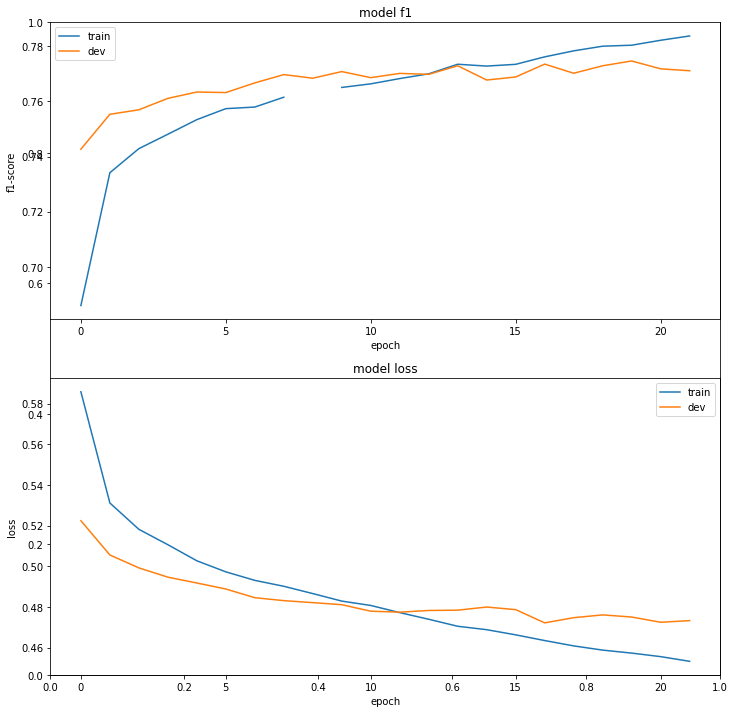

In [33]:
# summarize history for f1
fig, ax = plt.subplots(figsize=(12,12))
ax = fig.add_subplot(2,1,1)

ax.plot(history.history['f1'])
ax.plot(history.history['val_f1'])
ax.set_title('model f1')
ax.set_ylabel('f1-score')
ax.set_xlabel('epoch')
ax.legend(['train', 'dev'], loc='upper left')

ax = fig.add_subplot(2,1,2)
# summarize history for loss
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'dev'], loc='upper right')
fig.savefig("/content/gdrive/My Drive/keras_checkpoints/History_keras.pdf")
plt.show()

In [34]:
score = model.evaluate(
    X_test,
    y_test2,          
    batch_size=32,
    verbose=1)

print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
print('\nTest precision: %.4f' %  (score[1]))
print('\nTest recall: %.4f' %  (score[2]))
print('\nTest f1: %.4f' % (score[3]))
print('\nTest accuracy: %.4f'% (score[4]))

#128 64 32 -> best 0.7696
y_calc = model.predict_proba(X_test)
prec_dict, rec_dict, f1_dict = get_scores(y_test, y_calc, 0.5)
scores_df = pd.DataFrame.from_dict({'precision': prec_dict, 'recall': rec_dict, 'f1': f1_dict})
print(tabulate(scores_df.round(3), headers='keys', tablefmt='psql'))

9976/9976 [==============================] - 1s 103us/step

Test Binary_cross_entropy: 0.4631

Test precision: 0.7815

Test recall: 0.7815

Test f1: 0.7815

Test accuracy: 0.7815
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.78  |    0.792 | 0.786 |
| 1     |       0.783 |    0.77  | 0.777 |
| macro |       0.782 |    0.781 | 0.781 |
+-------+-------------+----------+-------+


In [35]:
print_classifier_scores(model, 'Keras MLP classifier', X_train, y_train
  , X_dev, y_dev
  , X_test, y_test,0.5)

Keras MLP classifier- Train scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.787 |    0.818 | 0.803 |
| 1     |       0.814 |    0.782 | 0.797 |
| macro |       0.8   |    0.8   | 0.8   |
+-------+-------------+----------+-------+
---------------------------------------------------------
Keras MLP classifier- Dev scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.766 |    0.783 | 0.774 |
| 1     |       0.776 |    0.759 | 0.768 |
| macro |       0.771 |    0.771 | 0.771 |
+-------+-------------+----------+-------+
---------------------------------------------------------
Keras MLP classifier- Test scores:
+-------+-------------+----------+-------+
|       |   precision |   recall |    f1 |
|-------+-------------+----------+-------|
| 0     |       0.78  |    0.792 | 0.786 |
| 1  

#### Precision - Recall Curve


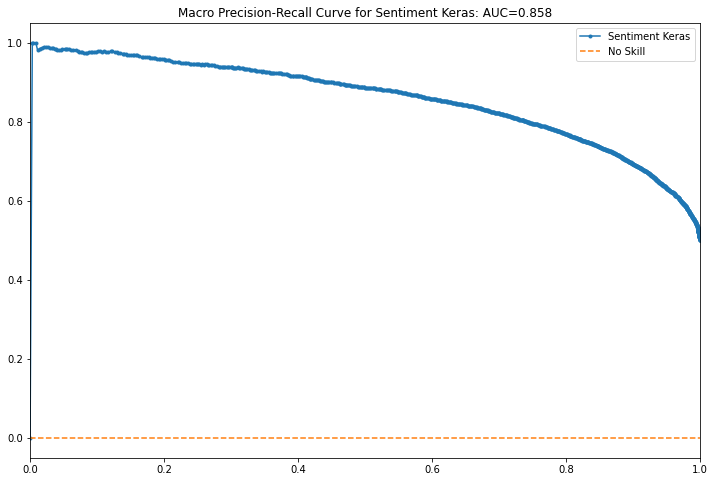

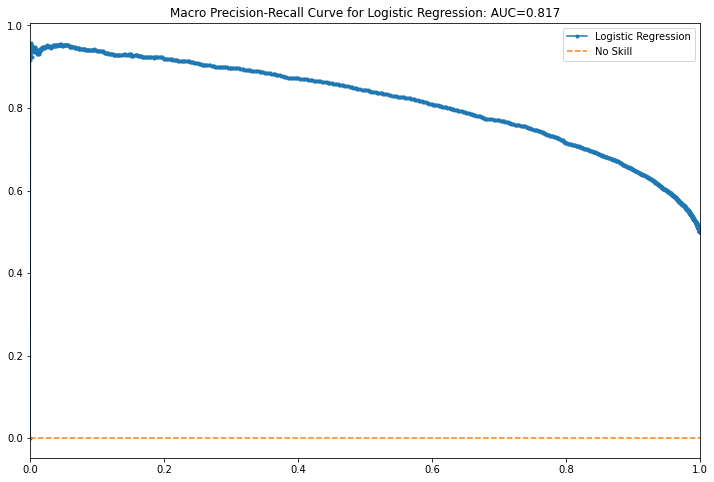

In [36]:
def plot_precision_recall_curve(estimator, estimator_name, X, y_true):
  # predict using given estimator
  y_pred = estimator.predict_proba(X)
  precisions = []
  recalls = []
  
  # thresholds list
  thres = np.linspace(0,1,1000)

  # keep scores for each threshold
  for t in thres:
    prec_dict, rec_dict, _ = get_scores(y_true, y_pred, t)

    precisions.append(prec_dict['macro'])
    recalls.append(rec_dict['macro'])

  # calculate area-under-curve
  area = auc(recalls, precisions)

  # plot
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title('Macro Precision-Recall Curve for %s: AUC=%0.3f' % (estimator_name,area))
  ax.plot(recalls, precisions, marker='.', label=estimator_name)
  ax.plot(thres,np.zeros(len(thres)), linestyle='--', label='No Skill')
  ax.set_xlim(0,1)
  ax.legend()
  fig.savefig("/content/gdrive/My Drive/keras_checkpoints/"+str(estimator_name)+"_PR_CURVE.pdf")


pipeline_list = [
                [model,'Sentiment Keras']
               ,[sgd,'Logistic Regression']
               ]

for pipe in pipeline_list:
  plot_precision_recall_curve(pipe[0], pipe[1], X_test, y_test)

#### Bootstrap Statistical Significance Tests

In [37]:
# Initialize classifiers ##########################################
# Base
y_pred = dummy.predict_proba(X_test)
_, _, bs_f1 = get_scores(y_test, y_pred, 0.5)
print('Base macro-f1: {:.4f}'.format( bs_f1['macro']))

# SGD
y_pred = sgd.predict_proba(X_test)
_, _, sgd_f1 = get_scores(y_test, y_pred, 0.5)
print('SGD macro-f1: {:.4f}'.format(sgd_f1['macro']))

# Keras
y_pred = model.predict_proba(X_test)
_, _, ks_f1 = get_scores(y_test, y_pred, 0.5)
print('Keras macro-f1: {:.4f}'.format( ks_f1['macro']))

Base macro-f1: 0.3304
SGD macro-f1: 0.7492
Keras macro-f1: 0.7814


In [38]:
# Bootstrapping significance test ###################################

def bootstrap_sign_test(best_estimator, comp_estimator, X, y, b, N):
  """
  Input:
    best_estimator: best scoring pipeline in terms of macro-f1
    comp_estimator: pipeline to be compared with the best
    X: array with X dataset
    y: 
    b: number of sampling datasets
    N: size of sampling datasets

  Output:
    p_value: p-value for the bootstrapping significance test
  """
  y1 = best_estimator.predict_proba(X)
  _, _, e1_f1 = get_scores(y, y1, 0.5)

  y2 = comp_estimator.predict_proba(X)
  _, _, e2_f1 = get_scores(y, y2, 0.5)
  
  # calculate true difference
  delta = e1_f1['macro'] - e2_f1['macro']

  diffs = []

  # calculate a diff for each simulated sample dataset
  for i in range(b):
    # generate N random indexes with replacement
    random_idx = np.random.choice(X.shape[0], N, replace=True) 
    bootstrap = X[random_idx, :]
    y_best = best_estimator.predict_proba( bootstrap )
    y_comp = comp_estimator.predict_proba( bootstrap )

    _, _, best_f1 = get_scores(y[random_idx], y_best, 0.5)
    _, _, comp_f1 = get_scores(y[random_idx], y_comp, 0.5)
    diffs.append(best_f1['macro'] - comp_f1['macro'])
  
  # calculate p-value
  s = 0
  for i in range(b):
    if diffs[i] > 2 * delta:
      s += 1
  p_value = s/b
  
  return p_value

# print p-values
start_time = time.time()

print('Keras vs Baseline, p_value:  {:.4f}' .format( bootstrap_sign_test(model, dummy, X_test, y_test, b = 1000, N = 1000) ))
print('Keras vs Logistic Regression, p_value: {:.4f}' .format( bootstrap_sign_test(model, sgd, X_test, y_test, b = 1000, N = 1000) ))

elapsed_time = time.time() - start_time

print('Elapsed time {:.0f} seconds'.format(elapsed_time))

Keras vs Baseline, p_value:  0.0000
Keras vs Logistic Regression, p_value: 0.0020
Elapsed time 148 seconds


#### Learning Curves

Process ended for trainsize: 10.0 % :
Process ended for trainsize: 16.42857142857143 % :
Process ended for trainsize: 22.857142857142858 % :
Process ended for trainsize: 29.285714285714292 % :
Process ended for trainsize: 35.71428571428572 % :
Process ended for trainsize: 42.142857142857146 % :
Process ended for trainsize: 48.57142857142858 % :
Process ended for trainsize: 55.00000000000001 % :
Process ended for trainsize: 61.42857142857143 % :
Process ended for trainsize: 67.85714285714286 % :
Process ended for trainsize: 74.28571428571429 % :
Process ended for trainsize: 80.71428571428572 % :
Process ended for trainsize: 87.14285714285715 % :
Process ended for trainsize: 93.57142857142858 % :
Process ended for trainsize: 100.0 % :


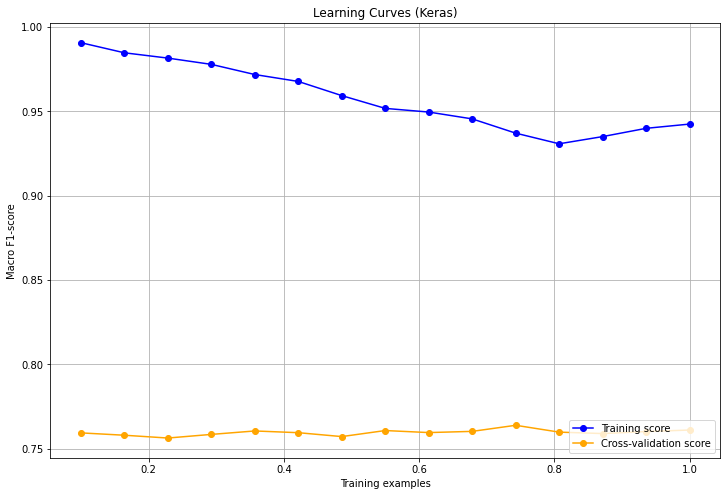

In [0]:
def plot_learning_curve(estimator, title, X, y, X_dev, y_dev, ylim=None, train_sizes=np.linspace(.1, 1.0, 5), is_keras=False):
   
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Macro F1-score")

  f1_train = []
  f1_dev = []

  # for each training subset, fit and predict
  for t_sz in train_sizes:
    X_subset = X[:int(t_sz * total_length)]
    y_subset = y[:int(t_sz * total_length)]

    # make y 2-dim if estimator is keras
    if is_keras==True:
      # fit MLP estimator
      y_subset2 = np.vstack(( 1-y_subset, y_subset)).T
      y_dev2 = np.vstack(( 1-y_dev, y_dev)).T
      
      estimator.fit(X_subset, y_subset2,
              batch_size=32,
              epochs=30,
              verbose = 0,
              #callbacks=my_callbacks, we dont need callbacks now
              #validation_data=(X_dev, y_dev2),
              shuffle=True)
    else:
        # fit sklearn estimator
        estimator.fit(X_subset, y_subset2)
      
    y_pred = estimator.predict_proba(X_subset)
    y_pred_dev = estimator.predict_proba(X_dev)

    _, _, f1_dict = get_scores(y_subset, y_pred, 0.5)
    _, _, f1_dict_dev = get_scores(y_dev, y_pred_dev, 0.5)
    f1_train.append(f1_dict['macro'])
    f1_dev.append(f1_dict_dev['macro'])
    print("Process ended for trainsize: {} % :".format(t_sz*100))

  ax.grid()
  ax.plot(train_sizes, f1_train, 'o-', color="b",
            label="Training score")
  ax.plot(train_sizes, f1_dev, 'o-', color="orange",
            label="Cross-validation score")

  ax.legend(loc="lower right")
  fig.savefig("/content/gdrive/My Drive/keras_checkpoints/"+title+'.pdf')

plot_learning_curve(model, "Learning Curves (Keras)"
                    , X_train, y_train
                    , X_dev, y_dev
                    , train_sizes = np.linspace(.1, 1.0, 15)
                    ,is_keras = True
                    )

### Appendix A - Randomized GridSearch

In [0]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

def my_model(layer_1_sz, layer_2_sz, layer_3_sz, drp_1, drp_2):
  model = Sequential()
  model.add(Dense(layer_1_sz, input_dim=X_train.shape[1] , activation='relu'))
  model.add(Dropout(drp_1))
  model.add(Dense(layer_2_sz,  activation='relu'))
  model.add(Dropout(drp_2))
  model.add(Dense(layer_3_sz,  activation='relu'))
  model.add(Dense(1,  activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
                  optimizer = Adam(lr=0.0001),
                  metrics=[precision, recall, f1, accuracy])
  return model

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

layer_1_sz = [256, 128, 64]
layer_2_sz = [256, 128, 64]
layer_3_sz =  [128, 64, 32]
drp_1 = [0.0, 0.3, 0.5]
drp_2 = [0.0, 0.3, 0.5]

model = KerasClassifier(build_fn = my_model, epochs=30, batch_size=32, verbose=1)

param_grid = dict(layer_1_sz = layer_1_sz, layer_2_sz = layer_2_sz, layer_3_sz = layer_3_sz, drp_1=drp_1,drp_2=drp_2)

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=10, scoring='f1_macro')
grid = RandomizedSearchCV(estimator=model
                          , param_distributions = param_grid
                          , n_jobs=1, cv=3, verbose=10
                          , scoring='f1_macro')
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] layer_3_sz=64, layer_2_sz=128, layer_1_sz=256, drp_2=0.5, drp_1=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
106426/106426 [==============================] - 21s 198us/step - loss: 0.5898 - precision: 0.6917 - recall: 0.6474 - f1: nan - accuracy: 0.6828
Epoch 2/30
106426/106426 [==============================] - 19s 175us/step - loss: 0.5282 - precision: 0.7458 - recall: 0.7192 - f1: 0.7254 - accuracy: 0.7383
Epoch 3/30
106426/106426 [==============================] - 18s 173us/step - loss: 0.5151 - precision: 0.7538 - recall: 0.7325 - f1: 0.7361 - accuracy: 0.7482
Epoch 4/30
106426/106426 [==============================] - 19s 174us/step - loss: 0.5066 - precision: 0.7601 - recall: 0.7374 - f1: 0.7417 - accuracy: 0.7533
Epoch 5/30
106426/106426 [==============================] - 19s 176us/step - loss: 0.5004 - precision: 0.7642 - recall: 0.7413 - f1: 0.7458 - accuracy: 0.7577
Epoch 6/30
106426/106426 [==============================] - 19s 174us/step - loss: 0.4961 - precision: 0.7658 - recall: 0.7446 - f1: 0.7485 - accuracy: 0.7596
Epoch 7/30
106426/106426 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.6min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 19s 175us/step - loss: 0.5891 - precision: 0.6933 - recall: 0.6649 - f1: 0.6687 - accuracy: 0.6836
Epoch 2/30
106427/106427 [==============================] - 18s 171us/step - loss: 0.5312 - precision: 0.7464 - recall: 0.7162 - f1: 0.7238 - accuracy: 0.7363
Epoch 3/30
106427/106427 [==============================] - 18s 172us/step - loss: 0.5177 - precision: 0.7533 - recall: 0.7281 - f1: 0.7333 - accuracy: 0.7449
Epoch 4/30
106427/106427 [==============================] - 18s 172us/step - loss: 0.5097 - precision: 0.7579 - recall: 0.7372 - f1: 0.7404 - accuracy: 0.7503
Epoch 5/30
106427/106427 [==============================] - 19s 180us/step - loss: 0.5050 - precision: 0.7633 - recall: 0.7384 - f1: 0.7439 - accuracy: 0.7547
Epoch 6/30
106427/106427 [==============================] - 18s 172us/step - loss: 0.4990 - precision: 0.7651 - recall: 0.7438 - f1: 0.7477 - accuracy: 0.7580
Epoch 7/30
106427/106427 [====================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.7min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 18s 171us/step - loss: 0.5954 - precision: 0.6897 - recall: 0.6361 - f1: nan - accuracy: 0.6783
Epoch 2/30
106427/106427 [==============================] - 17s 163us/step - loss: 0.5318 - precision: 0.7445 - recall: 0.7168 - f1: 0.7236 - accuracy: 0.7360
Epoch 3/30
106427/106427 [==============================] - 18s 170us/step - loss: 0.5176 - precision: 0.7544 - recall: 0.7291 - f1: 0.7349 - accuracy: 0.7464
Epoch 4/30
106427/106427 [==============================] - 18s 172us/step - loss: 0.5095 - precision: 0.7581 - recall: 0.7360 - f1: 0.7400 - accuracy: 0.7506
Epoch 5/30
106427/106427 [==============================] - 18s 167us/step - loss: 0.5027 - precision: 0.7625 - recall: 0.7404 - f1: 0.7445 - accuracy: 0.7552
Epoch 6/30
106427/106427 [==============================] - 18s 166us/step - loss: 0.4976 - precision: 0.7647 - recall: 0.7453 - f1: 0.7484 - accuracy: 0.7583
Epoch 7/30
106427/106427 [=======================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.6min remaining:    0.0s


Epoch 1/30
106426/106426 [==============================] - 18s 170us/step - loss: 0.5721 - precision: 0.7066 - recall: 0.6597 - f1: nan - accuracy: 0.6986
Epoch 2/30
106426/106426 [==============================] - 18s 168us/step - loss: 0.5211 - precision: 0.7492 - recall: 0.7216 - f1: 0.7277 - accuracy: 0.7410
Epoch 3/30
106426/106426 [==============================] - 18s 167us/step - loss: 0.5096 - precision: 0.7577 - recall: 0.7307 - f1: 0.7371 - accuracy: 0.7502
Epoch 4/30
106426/106426 [==============================] - 18s 172us/step - loss: 0.5012 - precision: 0.7616 - recall: 0.7372 - f1: 0.7424 - accuracy: 0.7542
Epoch 5/30
106426/106426 [==============================] - 18s 166us/step - loss: 0.4960 - precision: 0.7681 - recall: 0.7433 - f1: 0.7487 - accuracy: 0.7600
Epoch 6/30
106426/106426 [==============================] - 18s 172us/step - loss: 0.4906 - precision: 0.7696 - recall: 0.7450 - f1: 0.7505 - accuracy: 0.7622
Epoch 7/30
106426/106426 [=======================

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 36.6min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 18s 173us/step - loss: 0.5754 - precision: 0.7054 - recall: 0.6778 - f1: 0.6808 - accuracy: 0.6959
Epoch 2/30
106427/106427 [==============================] - 18s 166us/step - loss: 0.5242 - precision: 0.7478 - recall: 0.7244 - f1: 0.7288 - accuracy: 0.7403
Epoch 3/30
106427/106427 [==============================] - 18s 169us/step - loss: 0.5135 - precision: 0.7547 - recall: 0.7331 - f1: 0.7370 - accuracy: 0.7479
Epoch 4/30
106427/106427 [==============================] - 17s 161us/step - loss: 0.5053 - precision: 0.7593 - recall: 0.7381 - f1: 0.7419 - accuracy: 0.7524
Epoch 5/30
106427/106427 [==============================] - 18s 166us/step - loss: 0.4990 - precision: 0.7656 - recall: 0.7412 - f1: 0.7465 - accuracy: 0.7570
Epoch 6/30
106427/106427 [==============================] - 18s 167us/step - loss: 0.4940 - precision: 0.7697 - recall: 0.7441 - f1: 0.7501 - accuracy: 0.7607
Epoch 7/30
106427/106427 [====================

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 45.4min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 17s 162us/step - loss: 0.5764 - precision: 0.7019 - recall: 0.6778 - f1: 0.6806 - accuracy: 0.6947
Epoch 2/30
106427/106427 [==============================] - 18s 165us/step - loss: 0.5237 - precision: 0.7466 - recall: 0.7244 - f1: 0.7282 - accuracy: 0.7395
Epoch 3/30
106427/106427 [==============================] - 17s 164us/step - loss: 0.5127 - precision: 0.7543 - recall: 0.7347 - f1: 0.7373 - accuracy: 0.7479
Epoch 4/30
106427/106427 [==============================] - 17s 163us/step - loss: 0.5052 - precision: 0.7587 - recall: 0.7406 - f1: 0.7427 - accuracy: 0.7527
Epoch 5/30
106427/106427 [==============================] - 18s 167us/step - loss: 0.4988 - precision: 0.7621 - recall: 0.7433 - f1: 0.7461 - accuracy: 0.7561
Epoch 6/30
106427/106427 [==============================] - 18s 169us/step - loss: 0.4938 - precision: 0.7661 - recall: 0.7488 - f1: 0.7505 - accuracy: 0.7605
Epoch 7/30
106427/106427 [====================

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 54.1min remaining:    0.0s


Epoch 1/30
106426/106426 [==============================] - 17s 159us/step - loss: 0.5857 - precision: 0.6940 - recall: 0.6728 - f1: 0.6743 - accuracy: 0.6882
Epoch 2/30
106426/106426 [==============================] - 17s 155us/step - loss: 0.5279 - precision: 0.7453 - recall: 0.7181 - f1: 0.7241 - accuracy: 0.7373
Epoch 3/30
106426/106426 [==============================] - 17s 159us/step - loss: 0.5158 - precision: 0.7536 - recall: 0.7266 - f1: 0.7331 - accuracy: 0.7457
Epoch 4/30
106426/106426 [==============================] - 17s 159us/step - loss: 0.5084 - precision: 0.7578 - recall: 0.7326 - f1: 0.7383 - accuracy: 0.7505
Epoch 5/30
106426/106426 [==============================] - 16s 154us/step - loss: 0.5025 - precision: 0.7629 - recall: 0.7352 - f1: 0.7422 - accuracy: 0.7548
Epoch 6/30
106426/106426 [==============================] - 17s 158us/step - loss: 0.4990 - precision: 0.7652 - recall: 0.7400 - f1: 0.7459 - accuracy: 0.7581
Epoch 7/30
106426/106426 [====================

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 62.6min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 18s 167us/step - loss: 0.5939 - precision: 0.6879 - recall: 0.6382 - f1: nan - accuracy: 0.6806
Epoch 2/30
106427/106427 [==============================] - 17s 162us/step - loss: 0.5332 - precision: 0.7408 - recall: 0.7183 - f1: 0.7221 - accuracy: 0.7337
Epoch 3/30
106427/106427 [==============================] - 17s 159us/step - loss: 0.5213 - precision: 0.7483 - recall: 0.7256 - f1: 0.7297 - accuracy: 0.7407
Epoch 4/30
106427/106427 [==============================] - 17s 164us/step - loss: 0.5125 - precision: 0.7556 - recall: 0.7310 - f1: 0.7365 - accuracy: 0.7470
Epoch 5/30
106427/106427 [==============================] - 18s 166us/step - loss: 0.5068 - precision: 0.7581 - recall: 0.7334 - f1: 0.7388 - accuracy: 0.7502
Epoch 6/30
106427/106427 [==============================] - 18s 169us/step - loss: 0.5024 - precision: 0.7625 - recall: 0.7379 - f1: 0.7435 - accuracy: 0.7541
Epoch 7/30
106427/106427 [=======================

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 71.2min remaining:    0.0s


Epoch 1/30
106427/106427 [==============================] - 16s 151us/step - loss: 0.5882 - precision: 0.6962 - recall: 0.6505 - f1: nan - accuracy: 0.6856
Epoch 2/30
106427/106427 [==============================] - 16s 154us/step - loss: 0.5305 - precision: 0.7416 - recall: 0.7218 - f1: 0.7243 - accuracy: 0.7350
Epoch 3/30
106427/106427 [==============================] - 16s 149us/step - loss: 0.5191 - precision: 0.7502 - recall: 0.7293 - f1: 0.7328 - accuracy: 0.7435
Epoch 4/30
106427/106427 [==============================] - 16s 152us/step - loss: 0.5117 - precision: 0.7556 - recall: 0.7333 - f1: 0.7375 - accuracy: 0.7486
Epoch 5/30
106427/106427 [==============================] - 17s 156us/step - loss: 0.5055 - precision: 0.7594 - recall: 0.7369 - f1: 0.7418 - accuracy: 0.7526
Epoch 6/30
106427/106427 [==============================] - 16s 153us/step - loss: 0.5015 - precision: 0.7626 - recall: 0.7413 - f1: 0.7452 - accuracy: 0.7555
Epoch 7/30
106427/106427 [=======================

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 79.4min remaining:    0.0s


Epoch 1/30
106426/106426 [==============================] - 17s 159us/step - loss: 0.5946 - precision: 0.6906 - recall: 0.6336 - f1: nan - accuracy: 0.6797
Epoch 2/30
106426/106426 [==============================] - 17s 158us/step - loss: 0.5305 - precision: 0.7441 - recall: 0.7164 - f1: 0.7231 - accuracy: 0.7369
Epoch 3/30
106426/106426 [==============================] - 17s 157us/step - loss: 0.5180 - precision: 0.7518 - recall: 0.7260 - f1: 0.7320 - accuracy: 0.7444
Epoch 4/30
106426/106426 [==============================] - 17s 159us/step - loss: 0.5104 - precision: 0.7573 - recall: 0.7344 - f1: 0.7387 - accuracy: 0.7503
Epoch 5/30
106426/106426 [==============================] - 17s 163us/step - loss: 0.5041 - precision: 0.7624 - recall: 0.7389 - f1: 0.7438 - accuracy: 0.7556
Epoch 6/30
106426/106426 [==============================] - 18s 166us/step - loss: 0.5013 - precision: 0.7645 - recall: 0.7404 - f1: 0.7456 - accuracy: 0.7573
Epoch 7/30
106426/106426 [=======================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 253.8min finished


Epoch 1/30
159640/159640 [==============================] - 25s 160us/step - loss: 0.5589 - precision: 0.7210 - recall: 0.6883 - f1: 0.6941 - accuracy: 0.7110
Epoch 2/30
159640/159640 [==============================] - 26s 164us/step - loss: 0.5149 - precision: 0.7532 - recall: 0.7293 - f1: 0.7342 - accuracy: 0.7457
Epoch 3/30
159640/159640 [==============================] - 25s 158us/step - loss: 0.5041 - precision: 0.7603 - recall: 0.7366 - f1: 0.7414 - accuracy: 0.7528
Epoch 4/30
159640/159640 [==============================] - 25s 156us/step - loss: 0.4973 - precision: 0.7640 - recall: 0.7423 - f1: 0.7464 - accuracy: 0.7571
Epoch 5/30
159640/159640 [==============================] - 25s 156us/step - loss: 0.4919 - precision: 0.7677 - recall: 0.7454 - f1: 0.7498 - accuracy: 0.7605
Epoch 6/30
159640/159640 [==============================] - 24s 153us/step - loss: 0.4863 - precision: 0.7699 - recall: 0.7510 - f1: 0.7540 - accuracy: 0.7639
Epoch 7/30
159640/159640 [====================